In [1]:
import os
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

import pandas as pd

from IPython.display import Image

from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.analytic import UpperConfidenceBound

import warnings

import gymnasium as gym
import umap

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
force_cpu = True
if not force_cpu and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device", device)

Using device cpu


In [4]:
root = '.'
fig_folder = f"{root}/figures"
backup_folder = f"{root}/backup"

os.listdir(root)
for f in fig_folder, backup_folder:
    os.makedirs(f, exist_ok=True)

print("Backup folder:", backup_folder)
print("Figures folder:", fig_folder)

Backup folder: ./backup
Figures folder: ./figures


# Fix horizon

In [5]:
TIME_HORIZON = 20

# InvertedDoublePendulum env

In [6]:
def eval_trajectory(trajectory: np.ndarray) -> float:

    def scale_action(a):
        return a*6 - 3
    env = gym.make('InvertedPendulum-v4')  #gym.make_#gym.make('InvertedDoublePendulum-v4')
    observation, info = env.reset(seed=0)
    
    t = 0
    cum_reward = 0
    terminated, truncated = False, False
    while t < len(trajectory) and not terminated and not truncated:
        unscaled_action = trajectory[t]
        # unscaled between 0 and 1
        # scaled between - 3 and 3
        action = np.array([scale_action(unscaled_action), ])
        # action = env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
        cum_reward += reward
        t += 1
    return cum_reward / TIME_HORIZON


def eval_trajectories(trajectories: torch.Tensor, verbose: bool = False) -> torch.Tensor:
    x = trajectories.cpu().numpy()
    y = torch.zeros(len(x))
    for i, traj in enumerate(x):
        y[i] = eval_trajectory(traj)
    if verbose:
        print(f"Avg reward: {y.mean().item():.3f} +/- {y.std().item():.3f}; Range = {y.min().item():.3f}, {y.max().item():.3f}")
    return y 

# Using random policy

In [7]:
n_sample = 1000

x = torch.rand((n_sample, TIME_HORIZON))
eval_trajectories(x, verbose=True);

Avg reward: 0.302 +/- 0.169; Range = 0.150, 1.000


# Using unit gaussian

In [8]:
n_sample = 1000

x = torch.sigmoid(torch.randn((n_sample, TIME_HORIZON)))
eval_trajectories(x, verbose=True);

Avg reward: 0.371 +/- 0.206; Range = 0.150, 1.000


# Using reinforce

In [10]:
epochs = 1000 

mu = nn.Parameter(torch.randn(TIME_HORIZON))
logvar = nn.Parameter(torch.randn(TIME_HORIZON))
optimizer = optim.Adam([mu, logvar], lr=0.01)

n_sample = 20

kl_div_factor = 0.01
p = dist.Normal(torch.zeros(TIME_HORIZON), torch.ones(TIME_HORIZON))
# p = dist.ContinuousBernoulli(probs=torch.ones(n_steps)*0.5)
# p = None

hist_loss = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        
        optimizer.zero_grad()

        q = dist.Normal(mu, torch.exp(0.5*logvar))
        trajectories = torch.sigmoid(q.sample((n_sample, )))
        np_trajectories = trajectories.cpu().numpy()
        
        loss, total_weight = 0, 0
    
        for traj, np_traj in zip(trajectories, np_trajectories):
    
            reward = eval_trajectory(trajectory=np_traj)
            logp_traj = q.log_prob(traj).sum()
            loss -= logp_traj.exp() * reward
            total_weight += logp_traj.exp()

        loss /= total_weight
        
        if p is not None:
            kl_div = dist.kl_divergence(q, p).sum()
            loss += kl_div_factor * kl_div

        loss.backward()
        optimizer.step()

        pbar.update()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        hist_loss.append(loss.item())

with torch.no_grad():
    eval_trajectories(dist.Normal(mu, torch.exp(0.5*logvar)).sample((1000, )), verbose=True);

  0%|          | 0/1000 [00:00<?, ?it/s]

Avg reward: 0.221 +/- 0.107; Range = 0.150, 0.850


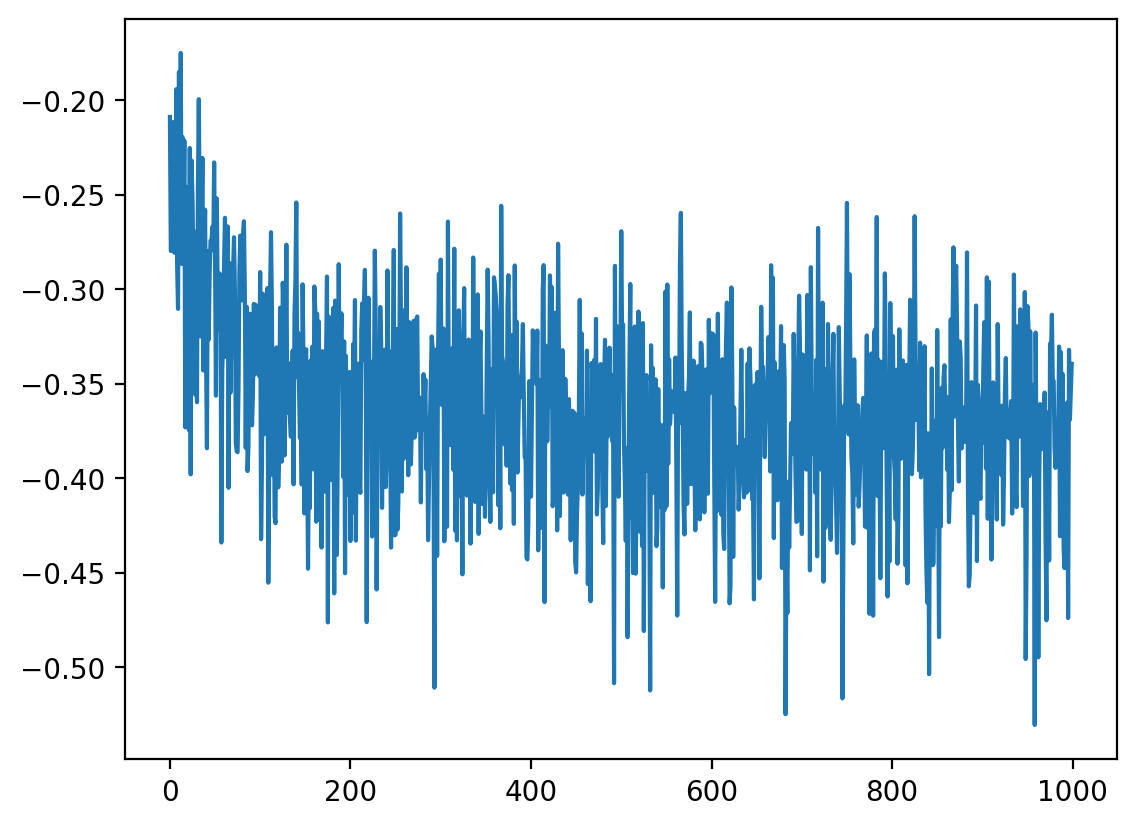

In [11]:
fig, ax = plt.subplots()
ax.plot(hist_loss);

# Creating a dataset

In [12]:
class TrajectoryDataset(Dataset): 
    def __init__(self, x, y):
        self.x = x
        self.y = y
        super().__init__()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [13]:
seed = 12345
n_sample = 2000

print("Creating samples for training...")

torch.manual_seed(seed)
x = torch.rand((n_sample, TIME_HORIZON))
y = eval_trajectories(x)

# Exclude best ones
# not_too_good = y <= 0.8
# y = y[not_too_good]
# x = x[not_too_good]

train_dataset = TrajectoryDataset(x=x.to(device), y=y.to(device))

print(f"avg = {y.mean():.3f} +/- {y.std():.3f}; range  = {y.min().item():.3f}, {y.max().item():.3f}")

Creating samples for training...
avg = 0.296 +/- 0.160; range  = 0.150, 1.000


In [14]:
seed = 1234
n_sample = 2000

print("Creating samples...")

torch.manual_seed(seed)
x = torch.rand((n_sample, TIME_HORIZON))
y = eval_trajectories(x)

# Exclude best ones
# not_too_good = y <= 0.8
# y = y[not_too_good]
# x = x[not_too_good]

test_dataset = TrajectoryDataset(x=x.to(device), y=y.to(device))

print(f"avg = {y.mean():.3f} +/- {y.std():.3f}; range  = {y.min().item():.3f}, {y.max().item():.3f}")

Creating samples...
avg = 0.303 +/- 0.166; range  = 0.150, 1.000


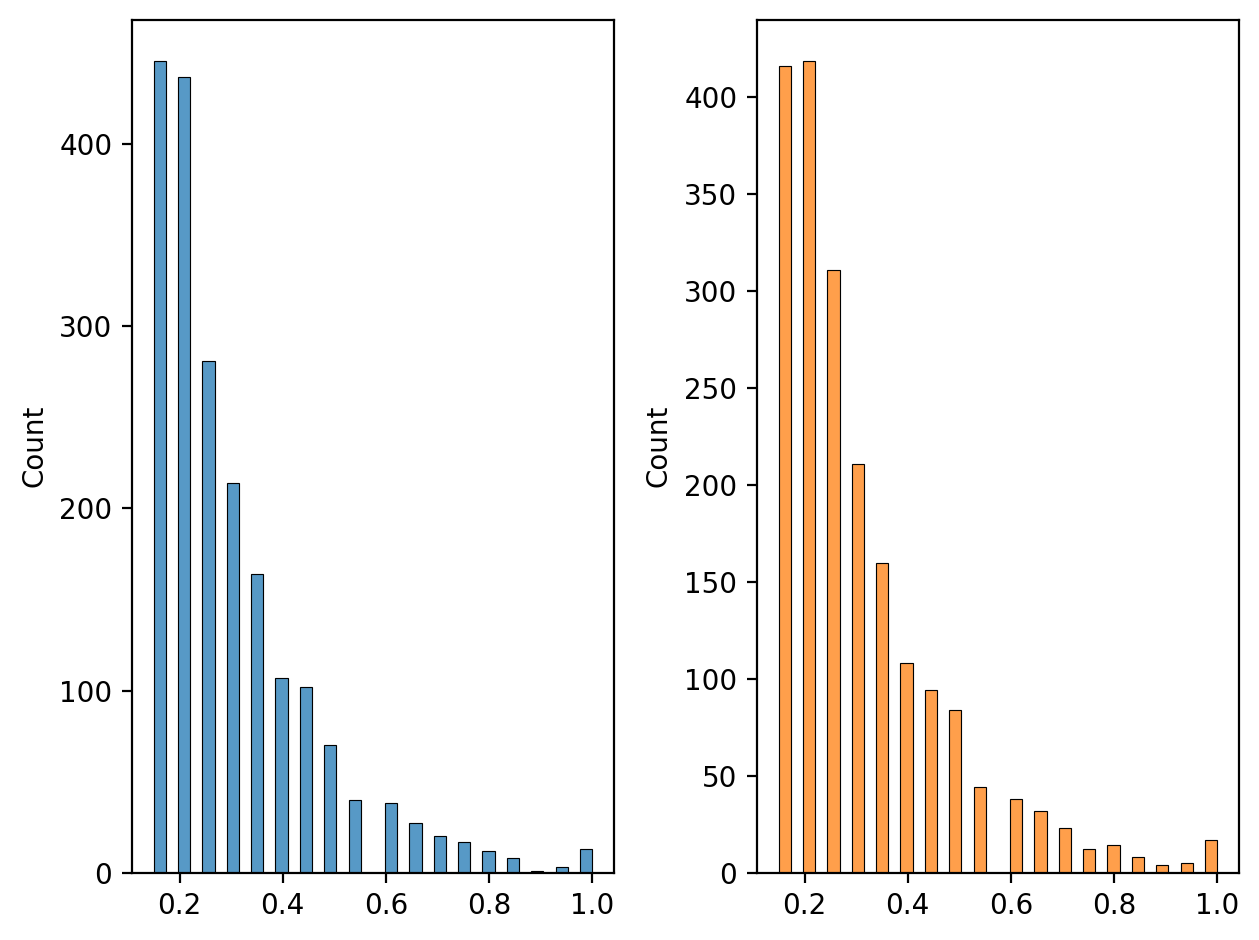

In [15]:
fig, axes = plt.subplots(ncols=2)
sns.histplot(ax=axes[0], x=train_dataset.y.cpu().numpy())
sns.histplot(ax=axes[1], x=test_dataset.y.cpu().numpy(), color="C1")
plt.tight_layout();

# VAE

In [17]:
rnn = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [19]:
output.shape

torch.Size([5, 3, 20])

In [20]:
hn.shape

torch.Size([2, 3, 20])

## Defining the VAE model

In [16]:
class VAE(nn.Module):
    def __init__(self, n_steps, size_z):
        super().__init__()

        self.enc = nn.GRU()
        self.mu = nn.Linear(500, size_z)
        self.logvar = nn.Linear(500, size_z)
        
        self.dec = nn.Sequential(
            nn.Linear(size_z, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, n_steps)
        )

    def encode(self, x):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.dec(z)
        x = torch.sigmoid(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred = nn.Sequential(
            nn.Linear(size_z, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 1)
        )
        
    def forward(self, x):
        x = self.pred(x)
        return x.squeeze()

## Training VAE

In [ ]:
def sumlogC( x , eps = 1e-5):

    # https://proceedings.neurips.cc/paper/2019/file/f82798ec8909d23e55679ee26bb26437-Paper.pdf
    # https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/blob/master/notebooks/Continuous_Bernoulli.ipynb
    
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

In [ ]:
def eval_reconstruction(model, dataset):
    x = dataset.x
    with torch.no_grad():
        mu, logvar = vae.encode(x)
        recon_x = vae.decode(mu)

    delta = torch.abs(x - recon_x)
    print(f"Avg reconstruction error: {delta.mean().item():.3f} +/- {delta.std().item():.3f}")
    

### Random level for reconstruction

In [ ]:
x = train_dataset.x
recon_x = torch.rand_like(x)
delta = torch.abs(x - recon_x)
print(f"Avg reconstruction error: {delta.mean().item():.3f} +/- {delta.std().item():.3f}")

### Training loop

In [ ]:
seed = 1234
size_z = 2
lr = 0.001
batch_size = len(train_dataset.y)
n_epoch = 1000

torch.manual_seed(seed)

vae = VAE(n_steps=TIME_HORIZON, size_z=size_z).to(device)
reg = Regression(size_z).to(device)

eval_reconstruction(vae, train_dataset)
eval_reconstruction(vae, test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

optimizer = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=lr)

hist_vae_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        vae_loss = 0 
        vae_rec_abs_err = 0
        reg_loss = 0
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer.zero_grad()

            recon_x, mu, logvar = vae(x)
            bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
            # https://arxiv.org/abs/1312.6114
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            # https://proceedings.neurips.cc/paper/2019/file/f82798ec8909d23e55679ee26bb26437-Paper.pdf
            # https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/blob/master/notebooks/Continuous_Bernoulli.ipynb
            logc = sumlogC(recon_x)
            l_vae = bce + 0.01*kl + logc 
            
            pred = reg(mu)
            l_reg = nn.MSELoss(reduction="sum")(target=y, input=pred)

            loss = l_vae + 0.001*l_reg
            
            loss.backward()
            optimizer.step()

            vae_loss += l_vae.item()
            vae_rec_abs_err += (recon_x - x).abs().sum()
            reg_loss += l_reg.item()

        hist_vae_loss.append(vae_loss/len(y))
        # if epoch > 0 and epoch % 50 == 0:
        pbar.update()
        pbar.set_postfix({
            "loss VAE": f"{vae_loss/len(y):.4f}",
            "rec Error": f"{vae_rec_abs_err/(len(y)*TIME_HORIZON):.3f}",
            "loss regression": f"{reg_loss/len(y):.4f}"
        })

eval_reconstruction(vae, train_dataset)
eval_reconstruction(vae, test_dataset)

## Visualize structuration of the latent space

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    mu, logvar = vae.encode(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    mu, logvar = vae.encode(x)
    z = mu
    x_rec = vae.decode(z)
    y_rec = eval_trajectories(x_rec)

all_y = torch.cat([y, y_rec])
vmin, vmax = all_y.min(), all_y.max()

z = z.cpu().numpy()
y_rec = y_rec.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y_rec,
    cmap="viridis",
    vmin=vmin, vmax=vmax,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

x_lim = min(z[:, 0]), max(z[:, 0]) 
y_lim = min(z[:, 1]), max(z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

# im = plt.contourf(gx, gy, gz, cmap='viridis')
fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) # vmin=0.0, vmax=1.0)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    dataset_z = mu.cpu().numpy()
    dataset_y = y.cpu().numpy()

x_lim = min(dataset_z[:, 0]), max(dataset_z[:, 0]) 
y_lim = min(dataset_z[:, 1]), max(dataset_z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    print(x.shape)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
ax.scatter(
    dataset_z[:, 0], dataset_z[:, 1], 
    c=dataset_y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)


fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_x, mu, logvar = vae(x)
    dataset_z = mu.cpu().numpy()
    x_prime = vae.decode(mu)
    x_prime = x_prime.cpu().numpy() 
    y = np.zeros(len(x_prime))
    for i in range(len(x_prime)):
        y[i] = eval_trajectory(trajectory=x_prime[i]) / TIME_HORIZON
    
    dataset_y = y

x_lim = min(dataset_z[:, 0]), max(dataset_z[:, 0]) 
y_lim = min(dataset_z[:, 1]), max(dataset_z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
ax.scatter(
    dataset_z[:, 0], dataset_z[:, 1], 
    c=dataset_y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)


fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

## Same thing but using the regressor from the latent

In [ ]:
vae.eval()
rx, ry = np.linspace(*x_lim, 20), np.linspace(*y_lim, 20)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()

    y = reg(z)
    
    # x = x.cpu().numpy()
    y = y.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz)  #, vmin=0.0, vmax=1.0);

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz) #, #vmin=0.0, vmax=1.0)

vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=3.0)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

# Using GP after VAE trained

In [ ]:
n_sample_start = 40

# Create a small dataset from the dataset the VAE has been trained with
best = torch.topk(train_dataset.y, k=n_sample_start).indices
train_x = train_dataset.x[best]
train_y = train_dataset.y[best]

# best_reward = train_y.max()
# train_y /= best_reward


with torch.no_grad():
    vae.eval()
    train_z, _ = vae.encode(train_dataset.x[best])

train_x = train_x.double()
train_y = train_y.double()
train_z = train_z.double()

fig, ax = plt.subplots()
ax.scatter(
    x=train_z[:, 0].numpy(), 
    y=train_z[:, 1].numpy(), 
    c=train_y.numpy(),  
    cmap="viridis");

In [ ]:


x_lim = -4, 4 
y_lim = -4, 4

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
plt.colorbar(im);

In [ ]:
bounds = torch.tensor([[-4.0] * size_z, [4.0] * size_z]).to(device)

n_sample_start = 500

# Create a small dataset from the dataset the VAE has been trained with
train_z = unnormalize(torch.rand(n_sample_start, size_z, device=device, dtype=dtype), bounds=bounds)


# best_reward = train_y.max()
# train_y /= best_reward


with torch.no_grad():
    vae.eval()
    train_x = vae.decode(train_z)
    train_y = torch.tensor([eval_trajectory(traj.cpu().numpy()) for traj in train_x]) / TIME_HORIZON

train_x = train_x.double()
train_y = train_y.double()
train_z = train_z.double()

fig, ax = plt.subplots()
im = ax.scatter(
    x=train_z[:, 0].numpy(), 
    y=train_z[:, 1].numpy(), 
    c=train_y.numpy(),  
    cmap="viridis")
plt.colorbar(im);

In [ ]:
torch.manual_seed(1234)

dtype=torch.float

acq_opt__batch_size = 20
acq_opt__num_restarts = 10
acq_opt__raw_samples = 256

qmc_sampler__sample_shape = 2048
qmc_sampler__seed = 123

n_batch = 20

best_observed = []
cand_observed = []
val_observed = []

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
with tqdm(total=n_batch) as pbar:
    for iteration in range(n_batch):

        # bound = torch.max(torch.tensor([-train_z.min(), train_z.max()]))

        # fit the GP model
        # normalize(train_h, bounds=bounds), 
        # standardize(train_obj) 
        normalized_train_z = normalize(train_z, bounds=bounds)
        standardized_train_y = standardize(train_y.unsqueeze(dim=1))
        # print(normalized_train_z)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = SingleTaskGP(train_X=normalized_train_z, train_Y=standardized_train_y)
        # if state_dict is not None:
        #     model.load_state_dict(state_dict)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        mll.to(device)
        fit_gpytorch_mll(mll)

        # define the qNEI acquisition module using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(
            sample_shape=qmc_sampler__sample_shape,
            seed=qmc_sampler__seed)
        acq_f = qExpectedImprovement(
            model=model, 
            sampler=qmc_sampler, 
            best_f=train_y.max())
        # acq_f = UpperConfidenceBound(model=model, beta=0.2)
        # optimize and get new observation
        # optimize
        candidates, _ = optimize_acqf(
            acq_function=acq_f,
            bounds=bounds,
            q=acq_opt__batch_size,
            num_restarts=acq_opt__num_restarts,
            raw_samples=acq_opt__raw_samples,
        )

        # observe new values 
        with torch.no_grad():
            new_z = unnormalize(candidates.detach(), bounds=bounds)
            new_x = vae.decode(new_z)
            new_y = torch.tensor([eval_trajectory(traj.cpu().numpy()) for traj in new_x]) / TIME_HORIZON

        # update training points
        train_z = torch.cat((train_z, new_z))
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))

        # update progress
        best_value = train_y.max().item()
        best_observed.append(best_value)
        for z, y in zip(new_z, new_y):
            cand_observed.append(z.numpy().tolist())
            val_observed.append(y.item())

        # state_dict = model.state_dict()
        
        pbar.update()
        pbar.set_postfix({"best": f"{best_value:.2f}"})

In [ ]:
fig, ax = plt.subplots()
ax.plot(best_observed);

In [ ]:
cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed).squeeze()

s = np.repeat(np.linspace(1, 10, n_batch)**2, acq_opt__batch_size)
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

fig, ax = plt.subplots()
im = ax.scatter(x=x, y=y, c=c, s=s, cmap="viridis")
plt.colorbar(im);

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

x_lim = min(z[:, 0]), max(z[:, 0]) 
y_lim = min(z[:, 1]), max(z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    print(x.shape)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

# im = plt.contourf(gx, gy, gz, cmap='viridis')
fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz)  #, vmin=0.0, vmax=1.0)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed).squeeze()

s = np.repeat(np.linspace(1, 10, n_batch)**2, acq_opt__batch_size)
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

ax.scatter(x=x, y=y, c=c, s=s, cmap="viridis");

In [ ]:
s = np.linspace(10, 50, len(val_observed))
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

In [ ]:
print(c.shape, s.shape, x.shape, y.shape)

In [ ]:
np.repeat([1, 2, 3], 3)

In [ ]:
x_lim = -40, 40
y_lim = -40, 40

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
plt.colorbar(im);